# Using scikit learn to test svr and krr 

### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### libraries for kernels with sk-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics.pairwise import rbf_kernel

ModuleNotFoundError: No module named 'sklearn'

### General system for damped oscillator
$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (egenfrekvens)
- $ t $: Time unit.


In [3]:
def damped_oscillator(t, y):  #remember that independent value t comes first
    zeta = 1*0.2/np.sqrt(2)
    omega_0 = 0.1 * 2* np.pi
    y_dot = - 2* zeta * omega_0 * y[1] - omega_0**2 * y[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [y[1], y_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

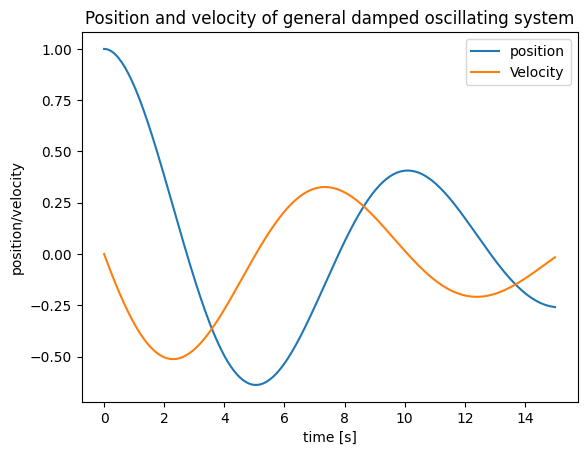

In [4]:
sol = solve_ivp(damped_oscillator, (0, 15), (1, 0), t_eval = np.linspace(0, 15, 300))#time interval first, then initial values for position and velocity
t = sol.t
x,y  = sol.y        #sol.y contains solutions for position and velocity calculated over t_eval as a 2d array

plt.plot(t, x, label = "position")
plt.plot(t, y, label = "Velocity")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

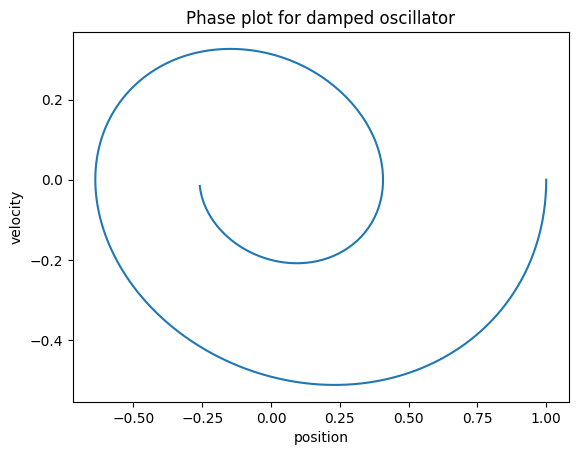

In [5]:
plt.plot(x, y)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### For the Undamped Pendulum

$$
\ddot{\theta}(t) + \frac{g}{L} \sin(\theta(t)) = 0
$$

#### Description of Variables:
- **$\theta(t)$**: The angle of the pendulum as a function of time
- **$\dot{\theta}(t)$**: The angular velocity
- **$\ddot{\theta}(t)$**: The angular acceleration 
- **$g$**: The acceleration due to gravity
- **$L$**: The length of the pendulum
- **$t$**: Time


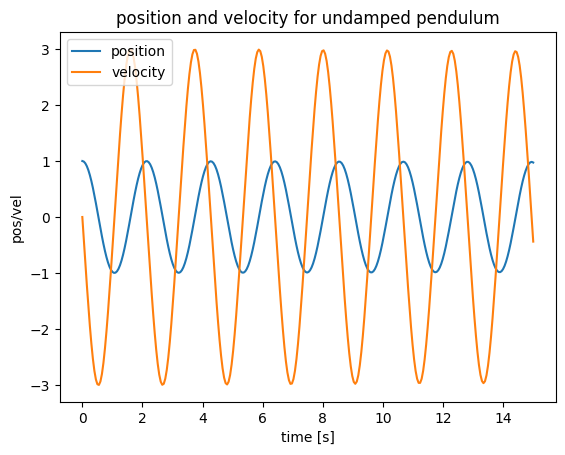

In [6]:
def pendulum(t, theta):
    g = 9.81
    l = 1
    theta_dot = - (g/l) * np.sin(theta[0])
    return [theta[1], theta_dot]
    
sol = solve_ivp(pendulum, (0, 15), (1, 0), t_eval= np.linspace(0, 15, 300))
x, y = sol.y 
t = sol.t
plt.plot(t, x, label = "position")
plt.plot(t, y, label = "velocity")
plt.xlabel("time [s]")
plt.ylabel("pos/vel")
plt.title("position and velocity for undamped pendulum")
plt.legend()
plt.show()


### Simulert data for hastighet og posisjon for en ekte pendel med støy

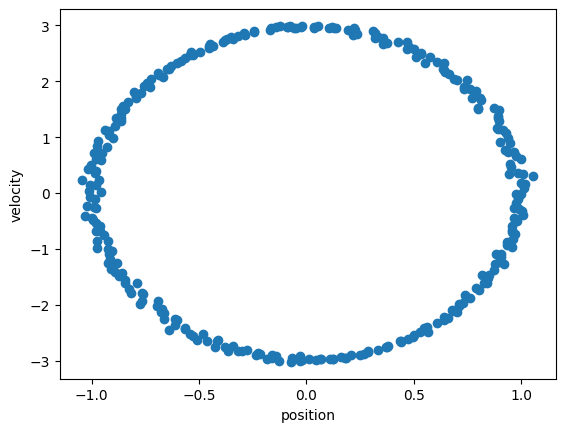

In [7]:
pos_data = x[::]
vel_data = y[::]
gaussian_noise = np.random.normal(0, 0.02, len(pos_data))
pos_data = pos_data + gaussian_noise
vel_data = vel_data + gaussian_noise
pos_data = np.column_stack((t, pos_data))
plt.plot(pos_data[:, 1], vel_data, 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()

### Del inn i test og train set og standardiser dataen


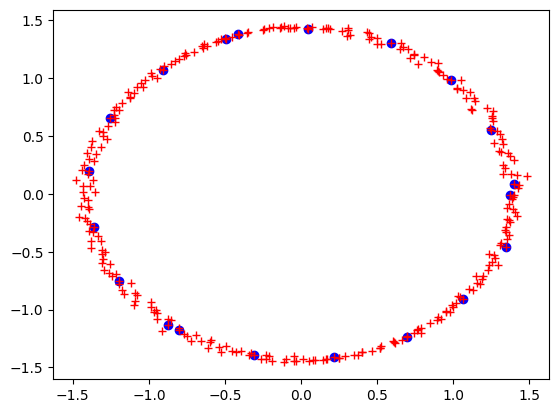

In [8]:
x_train = pos_data
y_train = np.reshape(vel_data, (-1, 1))
x_test = x_train[::15]
y_test= y_train[::15] 

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test)
plt.plot(x_test[:,1], y_test, 'bo')
plt.plot(x_train[:,1].reshape(-1,1), y_train, 'r+')
plt.show()

### lager SVR  for the systemet

C:\Users\Monhe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


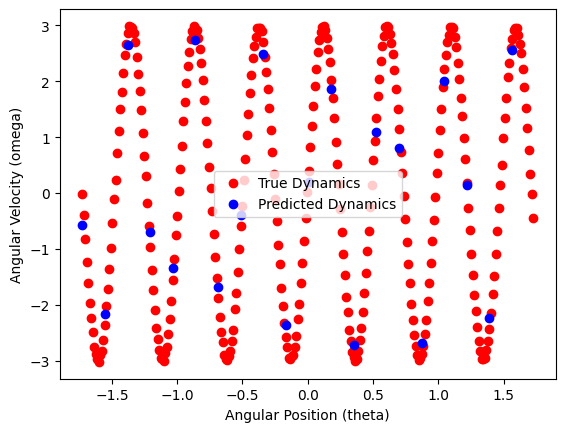

In [9]:
svr =  SVR(kernel = 'rbf', C=10, gamma = 10)

svr.fit(x_train, y_train)

y_pred = svr.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))
#x_train = scaler_x.inverse_transform(x_train)
#x_test = scaler_x.inverse_transform(x_test)

plt.plot(x_train[:,0], vel_data, 'o', color='red', label='True Dynamics', linewidth=2)
plt.plot(x_test[:,0], y_pred, 'o', color='blue', label='Predicted Dynamics')
plt.xlabel('Angular Position (theta)')
plt.ylabel('Angular Velocity (omega)')
plt.legend()
plt.show()

### Definerer en gausskernelen med egen kode

In [10]:
sigma = 1
lambd = 0.1
def gaussian_kernel(X, Y, sigma):
    return rbf_kernel(X, Y, gamma=1/(2*sigma**2))

# Solve the regularized least-squares problem
def learn_dynamics(X_train, Y_train, sigma, lambd):
    N = X_train.shape[0]
    
    # Compute the kernel matrix
    K = gaussian_kernel(X_train, Y_train, sigma)
    
    # Solve the linear system (K + N*lambda*I)A = Y_train
    A = np.linalg.solve(K + N * lambd * np.eye(N), Y_train)
    return A

A = learn_dynamics(x_train, x_train, sigma, lambd)
x_train

array([[-1.7262869 ,  1.37128435],
       [-1.71473983,  1.41734898],
       [-1.70319276,  1.3507968 ],
       [-1.69164569,  1.25658565],
       [-1.68009862,  1.1585525 ],
       [-1.66855155,  1.02020995],
       [-1.65700448,  0.9225765 ],
       [-1.64545741,  0.78857846],
       [-1.63391034,  0.51958364],
       [-1.62236327,  0.37181402],
       [-1.6108162 ,  0.14601922],
       [-1.59926913, -0.11089706],
       [-1.58772206, -0.23089536],
       [-1.57617499, -0.52413738],
       [-1.56462792, -0.72414122],
       [-1.55308085, -0.87150815],
       [-1.54153378, -0.98543814],
       [-1.52998671, -1.1747068 ],
       [-1.51843964, -1.29373688],
       [-1.50689257, -1.38205503],
       [-1.4953455 , -1.38947952],
       [-1.48379844, -1.39684845],
       [-1.47225137, -1.479337  ],
       [-1.4607043 , -1.34961219],
       [-1.44915723, -1.30163403],
       [-1.43761016, -1.19876296],
       [-1.42606309, -1.1394417 ],
       [-1.41451602, -0.98528448],
       [-1.40296895,

### Prediker dynamikken som er lært fra treningssettet på test settet

In [11]:
def predict_pendulum_dynamics(X_new, X_train, A, sigma):
    K_new = gaussian_kernel(X_new, X_train, sigma)
    return K_new.dot(A)

y_pred = predict_pendulum_dynamics(x_test, x_train, A, sigma)
kernel = gaussian_kernel(x_train, x_train, sigma)

#plt.plot(x_test[:,0], y_pred, 'o', label ='predicted dynamics')
#plt.plot(x_test[:,0], y_test, 'o', label = "exact dynamics")
#plt.legend()
#plt.show()